In [50]:
import sys
sys.path.append('/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/lcls_tools') # path to tools 
import common.data_analysis.archiver as arch # type: ignore
from datetime import datetime
from datetime import timedelta
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [51]:
from bs4 import BeautifulSoup

def get_pairs_of_dates(file_path): 
    # Open and read the local HTML file
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    # Create a BeautifulSoup object and specify the parser
    soup = BeautifulSoup(html_content, 'html.parser')
    dates = []
    times = []
    
    # Find all tags with class 'header_date'
    date_tags = soup.find_all(class_='header_date')
    for tag in date_tags:
        curr_date = tag.get_text(strip=True)
        dates.append(curr_date)
    
    # Find all tags with class 'header_time'
    time_tags = soup.find_all(class_='header_time')
    for tag in time_tags:
        curr_time = tag.get_text(strip=True)
        times.append(curr_time)
        
    datetimes = []
    
    for index in range(len(dates)):
        datetimes.append(f"{dates[index]} {times[index]}")
    
    date_lists = [[(datetime.strptime(datetimes[i], "%m/%d/%Y %H:%M") - timedelta(minutes=10)).strftime("%Y/%m/%d %H:%M:%S"), 
               datetime.strptime(datetimes[i], "%m/%d/%Y %H:%M").strftime("%Y/%m/%d %H:%M:%S")] for i in range(len(datetimes))]
    
    return date_lists

In [52]:
len(get_pairs_of_dates("/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/buncher_dates.html"))

100

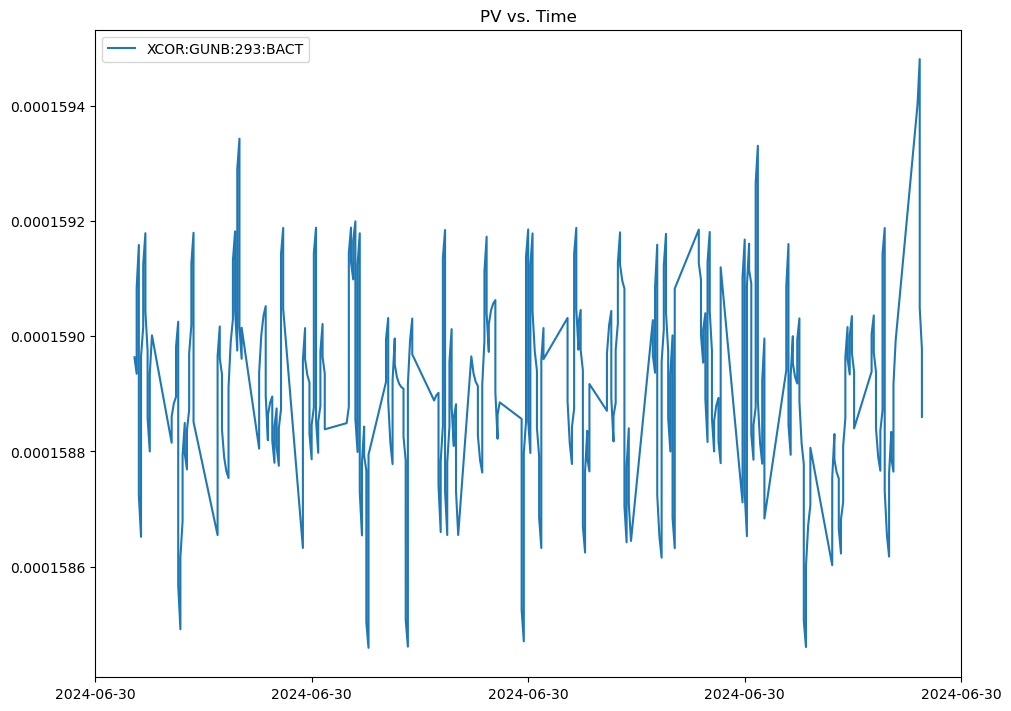

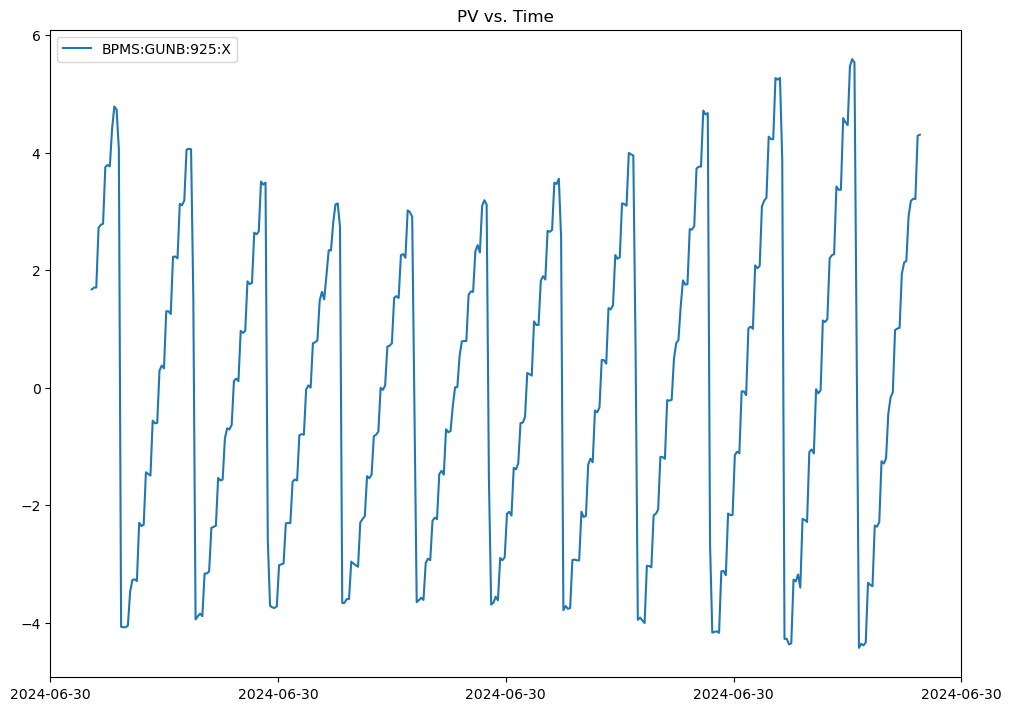

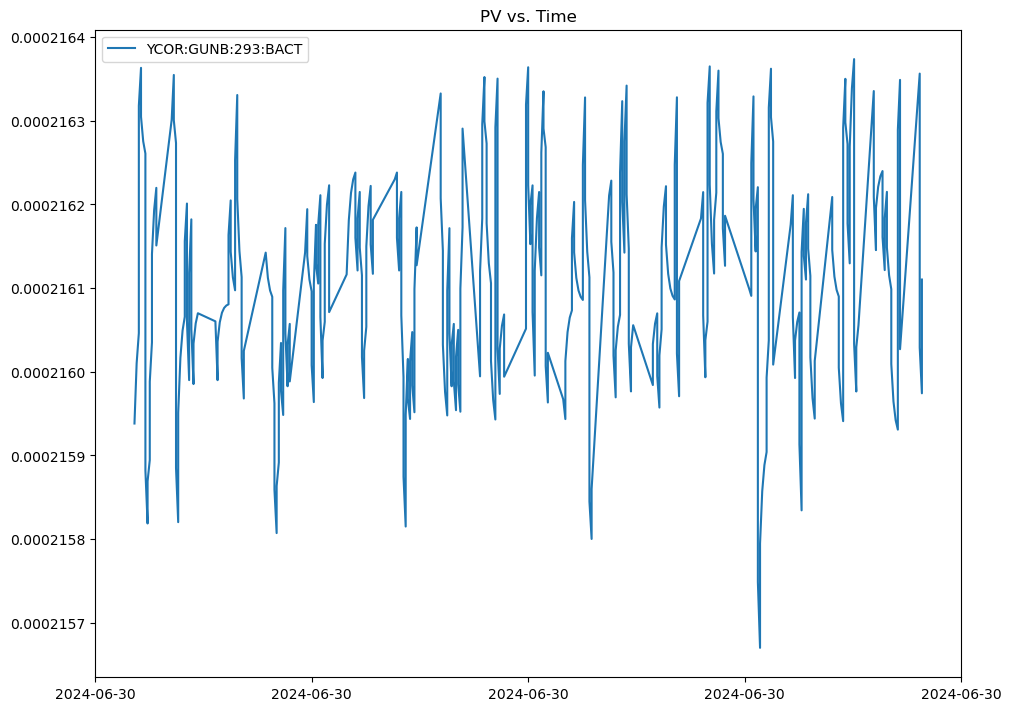

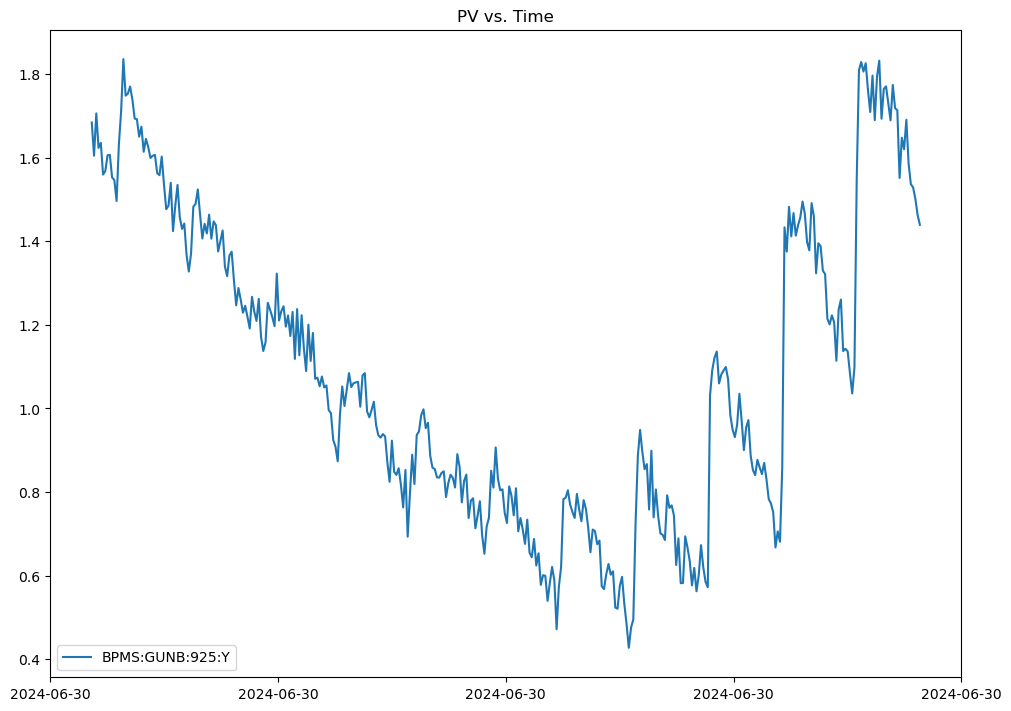

In [53]:
date = ("2024/06/30 09:50:00", "2024/06/30 09:56:00")
pv_xc = "XCOR:GUNB:293:BACT"
pv_bpx = "BPMS:GUNB:925:X"
pv_yc = "YCOR:GUNB:293:BACT"
pv_bpy = "BPMS:GUNB:925:Y"
pv_list = [pv_xc, pv_bpx, pv_yc, pv_bpy]

for x in range(4): 
    start_date = date[0]
    end_date = date[1]
    start_date_obj = datetime.strptime(start_date, "%Y/%m/%d %H:%M:%S")
    end_date_obj = datetime.strptime(end_date, "%Y/%m/%d %H:%M:%S")

    data = arch.get_values_over_time_range([pv_list[x]], start_date_obj, end_date_obj)
    data_dict = data[pv_list[x]]
    data_timestamps = data_dict.timestamps
    data_values = data_dict.values

    df = pd.DataFrame({"timestamps": data_timestamps, pv_list[x]: data_values})

    fig, ax = plt.subplots(figsize=(10, 7), layout='constrained')
    ax.plot(df["timestamps"], df[pv_list[x]], label=pv_list[x])
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_title("PV vs. Time") 
    ax.legend() 

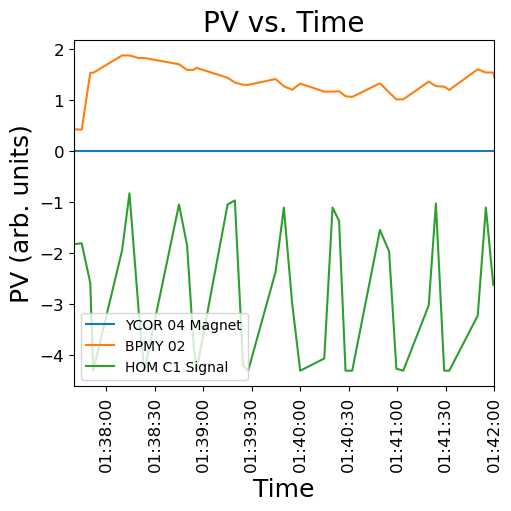

In [54]:
def plot_bunch_scan(pvs: list[str], paths: list[str], labels: list[str], mult_cor=True): 
    # create DataFrames for the PV over time
    df_cor = pd.read_csv(paths[0])
    df_bpm = pd.read_csv(paths[1])
    df_hom = pd.read_csv(paths[2])
    
    if mult_cor: 
        df_cor[pvs[0]] = df_cor[pvs[0]] * 10000
    df_hom[pvs[2]] = df_hom[pvs[2]] * 10
    
    df_hom["Timestamp"] = pd.to_datetime(df_hom["Timestamp"])
    df_cor["Timestamp"] = pd.to_datetime(df_cor["Timestamp"])
    df_bpm["Timestamp"] = pd.to_datetime(df_bpm["Timestamp"])
    
    df_correl = pd.merge_asof(df_hom, df_cor, tolerance=pd.Timedelta(seconds=10))
    df_all = pd.merge_asof(df_correl, df_bpm, tolerance=pd.Timedelta(seconds=10))
    df_all = df_all.dropna()
    
    fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
    
    plt.plot(df_all["Timestamp"], df_all[pvs[0]], label=labels[0])
    plt.plot(df_all["Timestamp"], df_all[pvs[1]], label=labels[1])
    plt.plot(df_all["Timestamp"], df_all[pvs[2]], label=labels[2])
    
    plt.xlim(df_all["Timestamp"][30], df_all["Timestamp"].max())
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Time", fontsize=18)
    plt.ylabel("PV (arb. units)", fontsize=18)
    plt.title("PV vs. Time", fontsize=20)
    plt.legend()
    
hom_pv = "SCOP:AMRF:RF01:AI_MEAS1"
xcor_pv = "XCOR:GUNB:713:BACT"  # XCOR 04
bpmx_pv = "BPMS:GUNB:925:X"  # BPMX 02
ycor_pv = "YCOR:GUNB:713:BACT"  # YCOR 04
bpmy_pv = "BPMS:GUNB:925:Y"  # BPMY 02

label_list_y = ["YCOR 04 Magnet", "BPMY 02", "HOM C1 Signal", "Charge"]
pv_list_y = [ycor_pv, bpmy_pv, hom_pv]
path_list_y = ["/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/YCOR04_SHORT.csv", 
               "/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/BPMY02_SHORT.csv", 
               "/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/HOMC1_SHORT.csv"]

label_list_x = ["XCOR 04 Magnet", "BPMX 02", "HOM C1 Signal", "Charge"]
pv_list_x = [xcor_pv, bpmx_pv, hom_pv]
path_list_x = ["/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/XCOR04_SHORT.csv", 
               "/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/BPMX02_SHORT.csv", 
               "/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/charge_separated_plots/epics_data/HOMC1_SHORT.csv"]

plot_bunch_scan(pv_list_y, path_list_y, label_list_y, mult_cor=False)

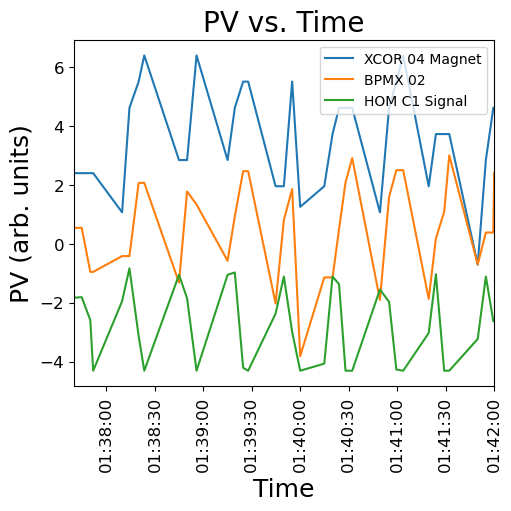

In [55]:
plot_bunch_scan(pv_list_x, path_list_x, label_list_x)